In [55]:
# !pip install google_play_scraper
# !pip install textblob
# !pip install seaborn

## Data Collection ##

Initial Setup

In [56]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

Get data from = "https://play.google.com/store/apps/details?id=com.gsm.customer.global&hl=id" an app customer to order an online taxi

In [57]:
#https://play.google.com/store/apps/details?id=com.gsm.customer.global&hl=id


from google_play_scraper import app, Sort, reviews_all

jkn_reviews = reviews_all(
    'com.gsm.customer.global',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

Save the data into a dataframe

In [58]:
df_jknrev = pd.DataFrame(np.array(jkn_reviews),columns=['content'])
df_jknrev = df_jknrev.join(pd.DataFrame(df_jknrev.pop('content').tolist()))

Mask username

In [59]:
def mask_username(username):
    if pd.isna(username):
        return username
    username = str(username)
    if len(username) <= 4:
        return "*" * len(username)
    return username[:2] + "*" * (len(username)-4) + username[-2:]

df_jknrev['userName'] = df_jknrev['userName'].apply(mask_username)

Save raw data (with username masking) to csv

In [60]:
df_jknrev.to_csv("raw_data.csv", index=False)

In [61]:
df_jknrev

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,8464f7f8-757c-40ab-8eb1-19566b11a16a,Di***********ti,https://play-lh.googleusercontent.com/a-/ALV-U...,"very neat and clean, the driver is very nice",5,0,None,2025-09-08 08:15:54,None,None,None
1,7cc21fd2-c527-463b-be80-e6459c4e4834,Ju********ot,https://play-lh.googleusercontent.com/a-/ALV-U...,"Aplikasi simple, mudah digunakan, lengkap dan ...",5,0,4.9.1,2025-09-08 07:17:42,None,None,4.9.1
2,06c464c1-746f-4c4d-92bd-1838006ac590,Pi********ys,https://play-lh.googleusercontent.com/a/ACg8oc...,"nyaman, bersih, driver ramah",5,0,4.9.1,2025-09-06 10:06:14,None,None,4.9.1
3,1cde6411-ef88-48c6-9a33-7fef6e13e426,Yu********as,https://play-lh.googleusercontent.com/a-/ALV-U...,"Apasih aplikasi ini nggak bisa login, mau otp ...",1,0,4.9.1,2025-09-05 13:03:53,None,None,4.9.1
4,a3fc8cfd-57e8-404a-bf57-885436c6a8a9,Dh*********ma,https://play-lh.googleusercontent.com/a-/ALV-U...,"belum coba, baru isi aplikasi semoga mobilnya ...",5,0,4.9.1,2025-09-04 21:07:21,None,None,4.9.1
...,...,...,...,...,...,...,...,...,...,...,...
185,da3fb7e4-61a1-4049-bd26-35732e2380e2,fi********am,https://play-lh.googleusercontent.com/a/ACg8oc...,"telah kirim ke email keluhan, paling bener nai...",1,17,3.36.1,2025-04-06 17:58:59,None,None,3.36.1
186,8d13bacc-1d77-4999-9c70-672fb54c3ef7,Ra*********ra,https://play-lh.googleusercontent.com/a-/ALV-U...,"Don't waste your time using this online taxi, ...",1,32,None,2025-04-05 16:46:42,None,None,None
187,55d3f7de-f9a0-4839-bfd8-940b3adeeed9,Ac*******ia,https://play-lh.googleusercontent.com/a-/ALV-U...,MOBIL TAKSI PALING NYAMAN. GAK BERISIK. AC DIN...,5,5,None,2025-04-03 20:44:10,None,None,None
188,57f1a7ca-f458-465e-b885-8f53a4dd48d2,Iv******ro,https://play-lh.googleusercontent.com/a/ACg8oc...,The cars used for Green SM taxis are very nice...,5,1,3.36.1,2025-04-03 07:55:59,None,None,3.36.1


In [62]:
df_jknrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              190 non-null    object        
 1   userName              190 non-null    object        
 2   userImage             190 non-null    object        
 3   content               190 non-null    object        
 4   score                 190 non-null    int64         
 5   thumbsUpCount         190 non-null    int64         
 6   reviewCreatedVersion  161 non-null    object        
 7   at                    190 non-null    datetime64[ns]
 8   replyContent          0 non-null      object        
 9   repliedAt             0 non-null      object        
 10  appVersion            161 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 16.5+ KB


# Data preprocessing #

Lowercasing

In [63]:
df_jknrev['content'] = df_jknrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print ("Before lowercasing:")
print(df_jknrev['content'][11])
print(df_jknrev['content'][1])
print(df_jknrev['content'][20])
print ("\nAfter lowercasing:")
df_jknrev['content']= df_jknrev['content'].apply(lambda x: x.lower())
print(df_jknrev['content'][11])
print(df_jknrev['content'][1])
print(df_jknrev['content'][20])

Before lowercasing:
you need to improve the accuracy of the map and it will be better if your driver can be reached by phone instead of long texting.
Aplikasi simple, mudah digunakan, lengkap dan fast respon.. Pertahankan yang sudah baik dan terus update agar semakin bagus kedepannya. Sukses selalu green SM .
layanan puas dan terbaik

After lowercasing:
you need to improve the accuracy of the map and it will be better if your driver can be reached by phone instead of long texting.
aplikasi simple, mudah digunakan, lengkap dan fast respon.. pertahankan yang sudah baik dan terus update agar semakin bagus kedepannya. sukses selalu green sm .
layanan puas dan terbaik


Tokenization

In [64]:
df_jknrev['tokens'] = df_jknrev['content'].str.lower().str.split()
all_tokens = [word for tokens in df_jknrev['tokens'] for word in tokens]
counter = Counter(all_tokens)
top_50 = counter.most_common(50)
print(top_50)

[('the', 57), ('and', 49), ('dan', 45), ('driver', 39), ('to', 38), ('di', 30), ('i', 28), ('ga', 24), ('is', 21), ('tidak', 20), ('app', 19), ('good', 18), ('taxi', 18), ('aplikasi', 17), ('yang', 17), ('my', 16), ('ada', 16), ('mobilnya', 15), ('mobil', 15), ('bisa', 14), ('saya', 14), ('ke', 14), ('this', 14), ('banyak', 13), ('for', 13), ('very', 12), ('sudah', 12), ('with', 12), ('green', 11), ('banget', 11), ('it', 11), ('a', 11), ('yg', 11), ('nice', 10), ('ramah', 10), ('ini', 10), ('baru', 10), ('car', 10), ('tapi', 10), ('drivernya', 10), ('sangat', 10), ('not', 10), ('bagus', 9), ('taksi', 9), ('pake', 9), ('untuk', 9), ('aplikasinya', 9), ('pick', 9), ('of', 8), ('in', 8)]


Stopword removal

In [65]:
# Create stopword remover
factory = StopWordRemoverFactory()
id_stopwords = set(factory.get_stop_words())

# Apply stopword removal to the 'content' column
df_jknrev['tokens_stopword_rm'] = df_jknrev['tokens'].apply(lambda tokens: [w for w in tokens if w not in id_stopwords])

In [66]:
nltk.download('stopwords')

english_stopwords = set(stopwords.words('english'))

df_jknrev['tokens_stopword_rm'] = df_jknrev['tokens_stopword_rm'].apply(
    lambda tokens: [w for w in tokens if w not in english_stopwords]
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Viggo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
print("stopwords removed:")
print (id_stopwords)
print (english_stopwords)

stopwords removed:
{'dst', 'bagi', 'atau', 'seperti', 'demi', 'selain', 'ada', 'seolah', 'para', 'tetapi', 'kah', 'dari', 'hal', 'daripada', 'ya', 'bagaimanapun', 'saat', 'nanti', 'melainkan', 'guna', 'akan', 'namun', 'lagi', 'seharusnya', 'toh', 'seterusnya', 'seraya', 'setiap', 'masih', 'dsb', 'oh', 'yaitu', 'sampai', 'setelah', 'kenapa', 'ketika', 'adalah', 'mereka', 'dengan', 'amat', 'oleh', 'dapat', 'dalam', 'tapi', 'saya', 'anu', 'anda', 'supaya', 'sebab', 'di', 'tanpa', 'kami', 'yakni', 'menurut', 'ingin', 'bisa', 'dua', 'jika', 'mengapa', 'antara', 'sekitar', 'boleh', 'ia', 'dimana', 'kembali', 'agak', 'pula', 'sudah', 'sebelum', 'sementara', 'pada', 'bahwa', 'sehingga', 'sedangkan', 'dan', 'terhadap', 'kepada', 'pasti', 'setidaknya', 'agar', 'hanya', 'dulunya', 'dahulu', 'secara', 'ini', 'mari', 'sesudah', 'demikian', 'dia', 'dll', 'itulah', 'selagi', 'belum', 'harus', 'nggak', 'sesuatu', 'sambil', 'saja', 'karena', 'ke', 'walau', 'maka', 'tidak', 'tentu', 'tolong', 'tentang',

In [68]:
df_jknrev['tokens_stopword_rm']

0                           [neat, clean,, driver, nice]
1      [aplikasi, simple,, mudah, digunakan,, lengkap...
2                      [nyaman,, bersih,, driver, ramah]
3      [apasih, aplikasi, login,, mau, otp, bisa,, pe...
4      [coba,, baru, isi, aplikasi, semoga, mobilnya,...
                             ...                        
185    [kirim, email, keluhan,, paling, bener, naik, ...
186    [waste, time, using, online, taxi,, driver, ru...
187    [mobil, taksi, paling, nyaman., gak, berisik.,...
188    [cars, used, green, sm, taxis, nice, luxurious...
189    [first, booking, using, new, app,, already, un...
Name: tokens_stopword_rm, Length: 190, dtype: object

Stemmering

In [69]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk import pos_tag

# --- download resource nltk (sekali saja) ---
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# --- init tools ---
lemmatizer = WordNetLemmatizer()
factory = StemmerFactory()
indo_stemmer = factory.create_stemmer()

# slang mapping
slang_dict = {
    "ngga": "tidak",
    "ga": "tidak",
    "gk": "tidak",
    "nggak": "tidak",
    "yg": "yang",
    "tp": "tapi",
    "drivernya": "driver"
}

# fungsi normalisasi 1 token
def normalize_word(w):
    w = w.lower()
    w = re.sub(r"[^\w]", "", w)  # buang tanda baca

    # slang replacement
    if w in slang_dict:
        return slang_dict[w]

    # buang sufiks umum Indo
    w = re.sub(r"(nya|lah|kah|pun|ku|mu)$", "", w)

    # buang prefix ter- (contoh: terkunci -> kunci)
    if w.startswith("ter") and len(w) > 4:
        w = w[3:]

    # English word
    if w.isascii() and w != "":
        pos = pos_tag([w])[0][1][0].upper()
        pos_map = {"J": "a", "N": "n", "V": "v", "R": "r"}
        return lemmatizer.lemmatize(w, pos_map.get(pos, "n"))

    # Indonesian word
    if w != "":
        return indo_stemmer.stem(w)

    return w

# --- apply ke seluruh dataframe ---
df_jknrev["tokens_stemmed"] = df_jknrev["tokens_stopword_rm"].apply(
    lambda tokens: [normalize_word(w) for w in tokens]
)

# cek hasil
print(df_jknrev[["tokens_stopword_rm", "tokens_stemmed"]].head(15))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Viggo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Viggo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Viggo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Viggo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


                                   tokens_stopword_rm  \
0                        [neat, clean,, driver, nice]   
1   [aplikasi, simple,, mudah, digunakan,, lengkap...   
2                   [nyaman,, bersih,, driver, ramah]   
3   [apasih, aplikasi, login,, mau, otp, bisa,, pe...   
4   [coba,, baru, isi, aplikasi, semoga, mobilnya,...   
5                            [unpleasant, experience]   
6                                    [good, response]   
7                                       [ok,, banget]   
8                   [menarik, adain, daerah, bandung]   
9                                       [blok, c, 11]   
10                           [cepat, kurang, 10menit]   
11  [need, improve, accuracy, map, better, driver,...   
12             [really, fall, love, clean, tidy, car]   
13  [pernah, minta, ganti, rute, pakai, apps, jara...   
14                                             [love]   

                                       tokens_stemmed  
0                         [neat

In [70]:
#Check number of reviews scores
df_jknrev['score'].value_counts()

score
5    111
1     54
3     11
2      9
4      5
Name: count, dtype: int64

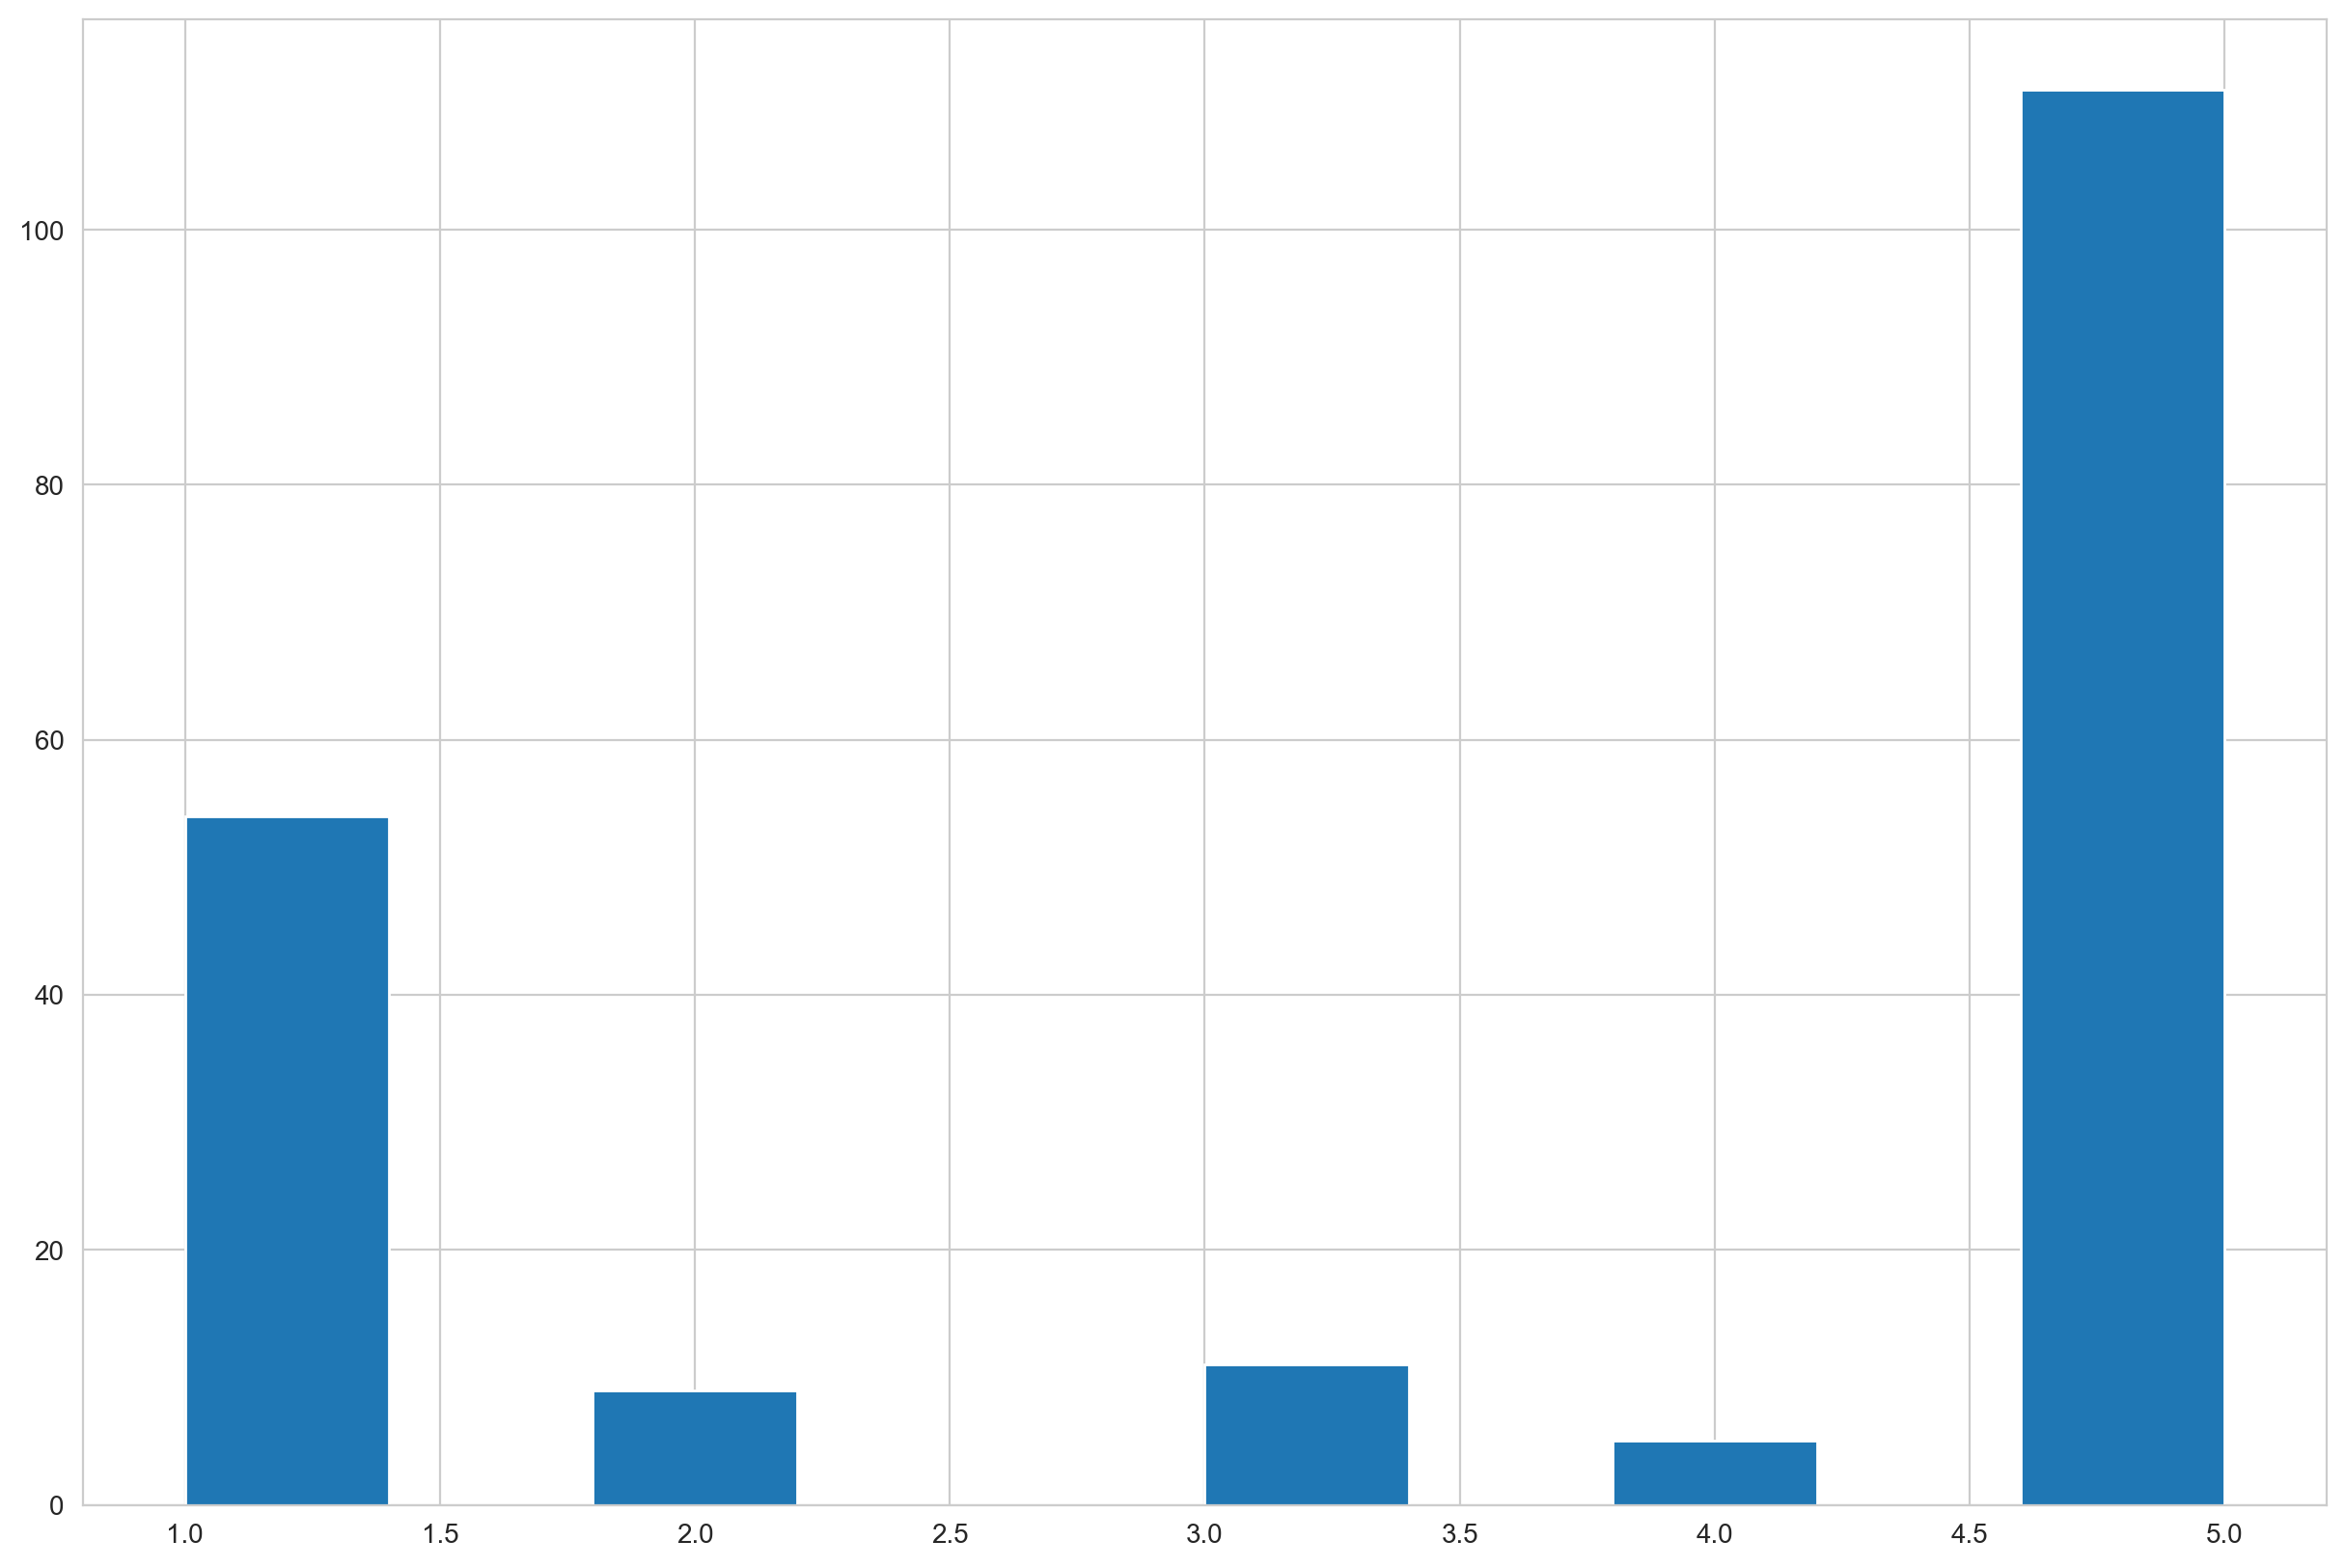

In [71]:
plt.hist(df_jknrev['score'])
plt.show()

In [72]:
df_jknrev

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,tokens,tokens_stopword_rm,tokens_stemmed
0,8464f7f8-757c-40ab-8eb1-19566b11a16a,Di***********ti,https://play-lh.googleusercontent.com/a-/ALV-U...,"very neat and clean, the driver is very nice",5,0,None,2025-09-08 08:15:54,None,None,None,"[very, neat, and, clean,, the, driver, is, ver...","[neat, clean,, driver, nice]","[neat, clean, driver, nice]"
1,7cc21fd2-c527-463b-be80-e6459c4e4834,Ju********ot,https://play-lh.googleusercontent.com/a-/ALV-U...,"aplikasi simple, mudah digunakan, lengkap dan ...",5,0,4.9.1,2025-09-08 07:17:42,None,None,4.9.1,"[aplikasi, simple,, mudah, digunakan,, lengkap...","[aplikasi, simple,, mudah, digunakan,, lengkap...","[aplikasi, simple, mudah, digunakan, lengkap, ..."
2,06c464c1-746f-4c4d-92bd-1838006ac590,Pi********ys,https://play-lh.googleusercontent.com/a/ACg8oc...,"nyaman, bersih, driver ramah",5,0,4.9.1,2025-09-06 10:06:14,None,None,4.9.1,"[nyaman,, bersih,, driver, ramah]","[nyaman,, bersih,, driver, ramah]","[nyaman, bersih, driver, ramah]"
3,1cde6411-ef88-48c6-9a33-7fef6e13e426,Yu********as,https://play-lh.googleusercontent.com/a-/ALV-U...,"apasih aplikasi ini nggak bisa login, mau otp ...",1,0,4.9.1,2025-09-05 13:03:53,None,None,4.9.1,"[apasih, aplikasi, ini, nggak, bisa, login,, m...","[apasih, aplikasi, login,, mau, otp, bisa,, pe...","[apasih, aplikasi, login, mau, otp, bisa, pera..."
4,a3fc8cfd-57e8-404a-bf57-885436c6a8a9,Dh*********ma,https://play-lh.googleusercontent.com/a-/ALV-U...,"belum coba, baru isi aplikasi semoga mobilnya ...",5,0,4.9.1,2025-09-04 21:07:21,None,None,4.9.1,"[belum, coba,, baru, isi, aplikasi, semoga, mo...","[coba,, baru, isi, aplikasi, semoga, mobilnya,...","[coba, baru, isi, aplikasi, semoga, mobil, ban..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,da3fb7e4-61a1-4049-bd26-35732e2380e2,fi********am,https://play-lh.googleusercontent.com/a/ACg8oc...,"telah kirim ke email keluhan, paling bener nai...",1,17,3.36.1,2025-04-06 17:58:59,None,None,3.36.1,"[telah, kirim, ke, email, keluhan,, paling, be...","[kirim, email, keluhan,, paling, bener, naik, ...","[kirim, email, keluhan, pal, bener, naik, grab..."
186,8d13bacc-1d77-4999-9c70-672fb54c3ef7,Ra*********ra,https://play-lh.googleusercontent.com/a-/ALV-U...,"don't waste your time using this online taxi, ...",1,32,None,2025-04-05 16:46:42,None,None,None,"[don't, waste, your, time, using, this, online...","[waste, time, using, online, taxi,, driver, ru...","[waste, time, use, online, taxi, driver, rude,..."
187,55d3f7de-f9a0-4839-bfd8-940b3adeeed9,Ac*******ia,https://play-lh.googleusercontent.com/a-/ALV-U...,mobil taksi paling nyaman. gak berisik. ac din...,5,5,None,2025-04-03 20:44:10,None,None,None,"[mobil, taksi, paling, nyaman., gak, berisik.,...","[mobil, taksi, paling, nyaman., gak, berisik.,...","[mobil, taksi, pal, nyaman, gak, berisik, ac, ..."
188,57f1a7ca-f458-465e-b885-8f53a4dd48d2,Iv******ro,https://play-lh.googleusercontent.com/a/ACg8oc...,the cars used for green sm taxis are very nice...,5,1,3.36.1,2025-04-03 07:55:59,None,None,3.36.1,"[the, cars, used, for, green, sm, taxis, are, ...","[cars, used, green, sm, taxis, nice, luxurious...","[car, use, green, sm, taxi, nice, luxurious, s..."


In [73]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

C:\Users\Viggo\AppData\Local\Temp\ipykernel_34080\2152088084.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


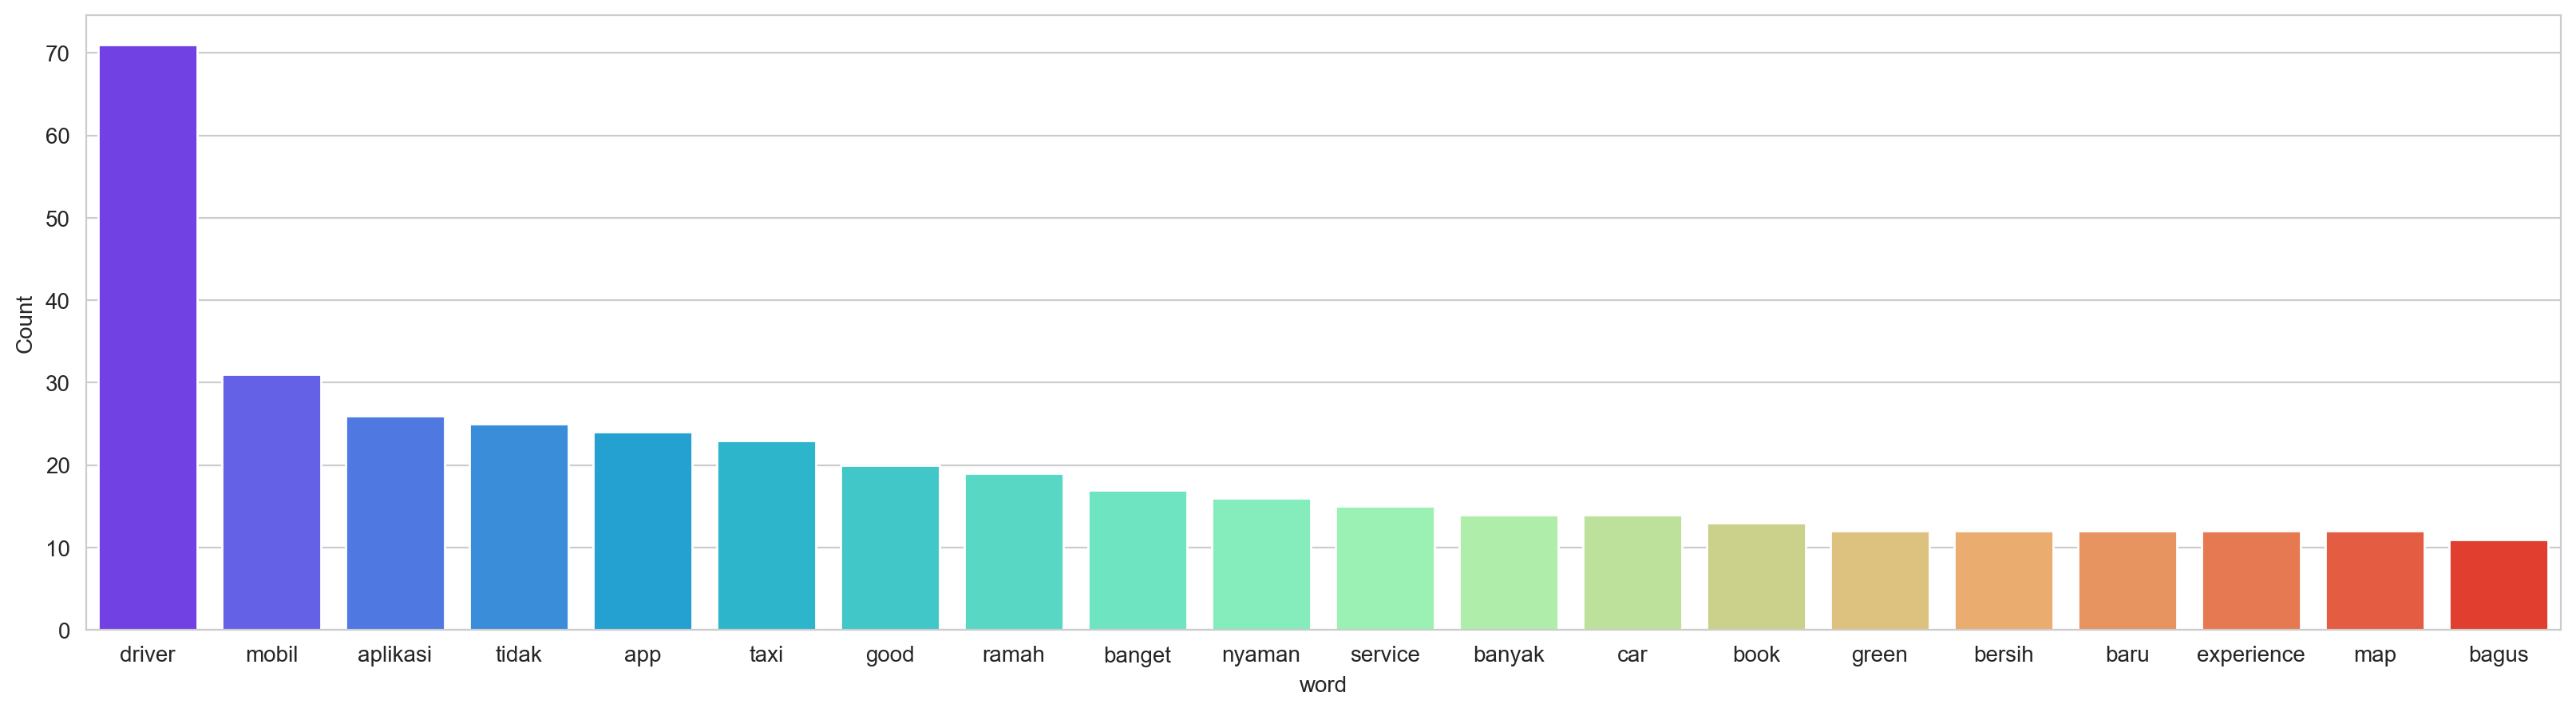

In [74]:
freq_words(df_jknrev['tokens_stemmed'].apply(lambda x: ' '.join(x)), 20)

In [75]:
custom_stopwords = {"driver", "aplikasi", "app", "car"}

df_jknrev['Cleaned_Text'] = df_jknrev['tokens_stemmed'].apply(
    lambda tokens: ' '.join([word for word in tokens if word not in custom_stopwords])
)

print(df_jknrev[['tokens_stemmed', 'Cleaned_Text']].head())


                                      tokens_stemmed  \
0                        [neat, clean, driver, nice]   
1  [aplikasi, simple, mudah, digunakan, lengkap, ...   
2                    [nyaman, bersih, driver, ramah]   
3  [apasih, aplikasi, login, mau, otp, bisa, pera...   
4  [coba, baru, isi, aplikasi, semoga, mobil, ban...   

                                        Cleaned_Text  
0                                    neat clean nice  
1  simple mudah digunakan lengkap fast respon per...  
2                                nyaman bersih ramah  
3     apasih login mau otp bisa perangkat kunci mulu  
4                  coba baru isi semoga mobil banyak  


In [76]:
df_jknrev['content'] = df_jknrev['Cleaned_Text'].astype(str)

In [77]:
df_to_save = df_jknrev.drop(columns=["tokens", "tokens_stopword_rm", "Cleaned_Text", "Cleaned_Text"])

df_to_save.to_csv("cleaned_data.csv", index=False)



In [78]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

In [79]:
freq_words(df_jknrev['custom_stopword'], 20)

KeyError: 'custom_stopword'

In [ ]:
df_jknrev

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,tokens,tokens_stopword_rm,tokens_stemmed,custom_stopword
0,06c464c1-746f-4c4d-92bd-1838006ac590,Pi********ys,https://play-lh.googleusercontent.com/a/ACg8ocLqqoqVT9VMJnazvLuXn7NNZxYnZlTkc-8iWfT-a5Kw1A9-t8f6=mo,"nyaman, bersih, driver ramah",5,0,4.9.1,2025-09-06 10:06:14,None,None,4.9.1,"[nyaman,, bersih,, driver, ramah]","[nyaman,, bersih,, driver, ramah]","[nyaman, bersih, driver, ramah]",nyaman bersih ramah
1,1cde6411-ef88-48c6-9a33-7fef6e13e426,Yu********as,https://play-lh.googleusercontent.com/a-/ALV-UjVD-HcucxI74ePJuXzkVFMtz1MPSXklcV6f9SfvAbY2uXIiRB2f,"apasih aplikasi ini nggak bisa login, mau otp nggak bisa, perangkat anda terkunci mulu",1,0,4.9.1,2025-09-05 13:03:53,None,None,4.9.1,"[apasih, aplikasi, ini, nggak, bisa, login,, mau, otp, nggak, bisa,, perangkat, anda, terkunci, mulu]","[apasih, aplikasi, login,, mau, otp, bisa,, perangkat, terkunci, mulu]","[apasih, aplikasi, login, mau, otp, bisa, perangkat, kunci, mulu]",apasih login mau otp bisa perangkat kunci mulu
2,a3fc8cfd-57e8-404a-bf57-885436c6a8a9,Dh*********ma,https://play-lh.googleusercontent.com/a-/ALV-UjVmkcaGn-DpFa1w1PfwW4IBlWWxEuM6e05cY3uTuqxZw-KZzkP2SA,"belum coba, baru isi aplikasi semoga mobilnya banyak",5,0,4.9.1,2025-09-04 21:07:21,None,None,4.9.1,"[belum, coba,, baru, isi, aplikasi, semoga, mobilnya, banyak]","[coba,, baru, isi, aplikasi, semoga, mobilnya, banyak]","[coba, baru, isi, aplikasi, semoga, mobil, banyak]",coba baru isi semoga mobil banyak
3,7a414094-352b-4803-a5ff-6f8b23490721,He***********ah,https://play-lh.googleusercontent.com/a-/ALV-UjXR3h1RGLzXBs71ya6vZbKH0n-cLIb4Z9ahq-gFbqgP7yEzJig,unpleasant experience,1,0,None,2025-09-04 19:15:33,None,None,None,"[unpleasant, experience]","[unpleasant, experience]","[unpleasant, experience]",unpleasant experience
4,e243be58-c004-4ba5-8443-d136eb1e3754,Su***********no,https://play-lh.googleusercontent.com/a-/ALV-UjUgzoQxkkjYYP7bNtmZZCZbQ27ukFTfG0_-FigAaLKUfaMsuIwNng,very good response,4,0,4.9.1,2025-09-04 16:41:02,None,None,4.9.1,"[very, good, response]","[good, response]","[good, response]",good response
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,da3fb7e4-61a1-4049-bd26-35732e2380e2,fi********am,https://play-lh.googleusercontent.com/a/ACg8ocII3EVYNW8But1IYt4CIyieuWTXW6f6U2KwBW-a5FsvAU4imQ=mo,"telah kirim ke email keluhan, paling bener naik grab/gojek/blubird",1,17,3.36.1,2025-04-06 17:58:59,None,None,3.36.1,"[telah, kirim, ke, email, keluhan,, paling, bener, naik, grab/gojek/blubird]","[kirim, email, keluhan,, paling, bener, naik, grab/gojek/blubird]","[kirim, email, keluhan, pal, bener, naik, grabgojekblubird]",kirim email keluhan pal bener naik grabgojekblubird
184,8d13bacc-1d77-4999-9c70-672fb54c3ef7,Ra*********ra,https://play-lh.googleusercontent.com/a-/ALV-UjUUGaXuw5suww5eBbXGSuUlviSWOlPqOKPd10xeKNRHgMh4asw,"don't waste your time using this online taxi, the driver is very rude and driving very dangerously i was humiliated a lot during my first ride with them. never going to use them again ever",1,32,None,2025-04-05 16:46:42,None,None,None,"[don't, waste, your, time, using, this, online, taxi,, the, driver, is, very, rude, and, driving, very, dangerously, i, was, humiliated, a, lot, during, my, first, ride, with, them., never, going,...","[waste, time, using, online, taxi,, driver, rude, driving, dangerously, humiliated, lot, first, ride, them., never, going, use, ever]","[waste, time, use, online, taxi, driver, rude, drive, dangerously, humiliate, lot, first, ride, them, never, go, use, ever]",waste time use online taxi rude drive dangerously humiliate lot first ride them never go use ever
185,55d3f7de-f9a0-4839-bfd8-940b3adeeed9,Ac*******ia,https://play-lh.googleusercontent.com/a-/ALV-UjU37rm7rxdAEcKQzo6eMRT-m7P1HjRec_kxKnEH9XC2AHcu5N2f,mobil taksi paling nyaman. gak berisik. ac dingin.. rute kelapa gading ke kemayoran juga murah. driver ramah.,5,5,None,2